In [14]:
import pandas as pd

main_df = pd.read_csv('./data/bsm_data_train.csv')
main_df = main_df.drop_duplicates('ident_bag', keep='first').reset_index(drop=True)

# Формирование целевой переменной

In [15]:
main_df['MessageReceivedMinutes'] = pd.to_datetime(main_df['MessageReceivedDate']).apply(lambda x: x.value) / 1000000000 // 60
main_df['MessageReceivedMinutes'] = main_df['MessageReceivedMinutes'].astype(int)
main_df['MessageReceivedMinutes'] -= main_df['MessageReceivedMinutes'].min()
main_df = main_df.sort_values(by='MessageReceivedMinutes')

main_df['ProcessingTime'] = (pd.to_datetime(main_df.MessageProcessedDate) - pd.to_datetime(main_df.MessageReceivedDate)).apply(lambda x: x.seconds)

In [3]:
target = main_df.MessageReceivedMinutes.value_counts().sort_index()

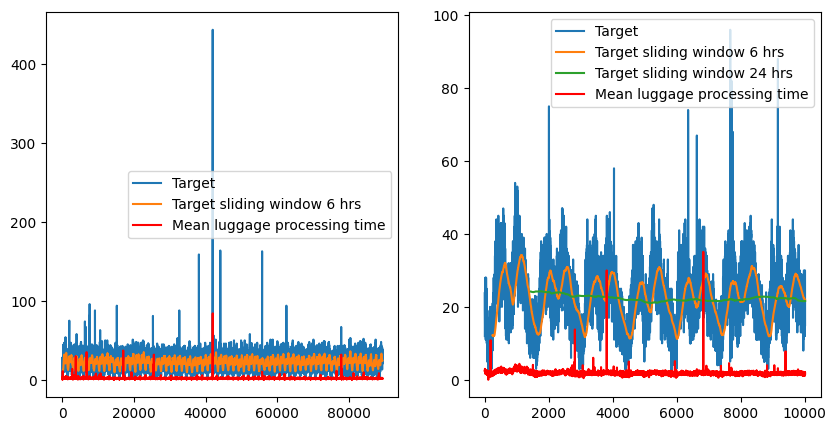

In [4]:
import matplotlib.pyplot as plt


fig, axes = plt.subplots(ncols=2, figsize=(10, 5))

axes[0].plot(target, label='Target')
axes[0].plot(target.rolling(240).mean(), label='Target sliding window 6 hrs')
axes[0].plot(main_df.groupby('MessageReceivedMinutes').ProcessingTime.mean(), color='red', label='Mean luggage processing time')
axes[0].legend()

axes[1].plot(target[:10000], label='Target')
axes[1].plot(target[:10000].rolling(240).mean(), label='Target sliding window 6 hrs')
axes[1].plot(target[:10000].rolling(1440).mean(), label='Target sliding window 24 hrs')
axes[1].plot(main_df.groupby('MessageReceivedMinutes').ProcessingTime.mean()[:10000], color='red', label='Mean luggage processing time')

axes[1].legend()

# Доп данные + EDA

In [5]:
rasp_data = pd.read_csv('./data/flight_rasp_data.csv')
main_df = main_df.join(rasp_data.set_index('i_id'), on='i_id')
main_df = main_df.drop(columns=['pax_id_hash', 'DateEvent', 't_st', 'm_city_rus1'])

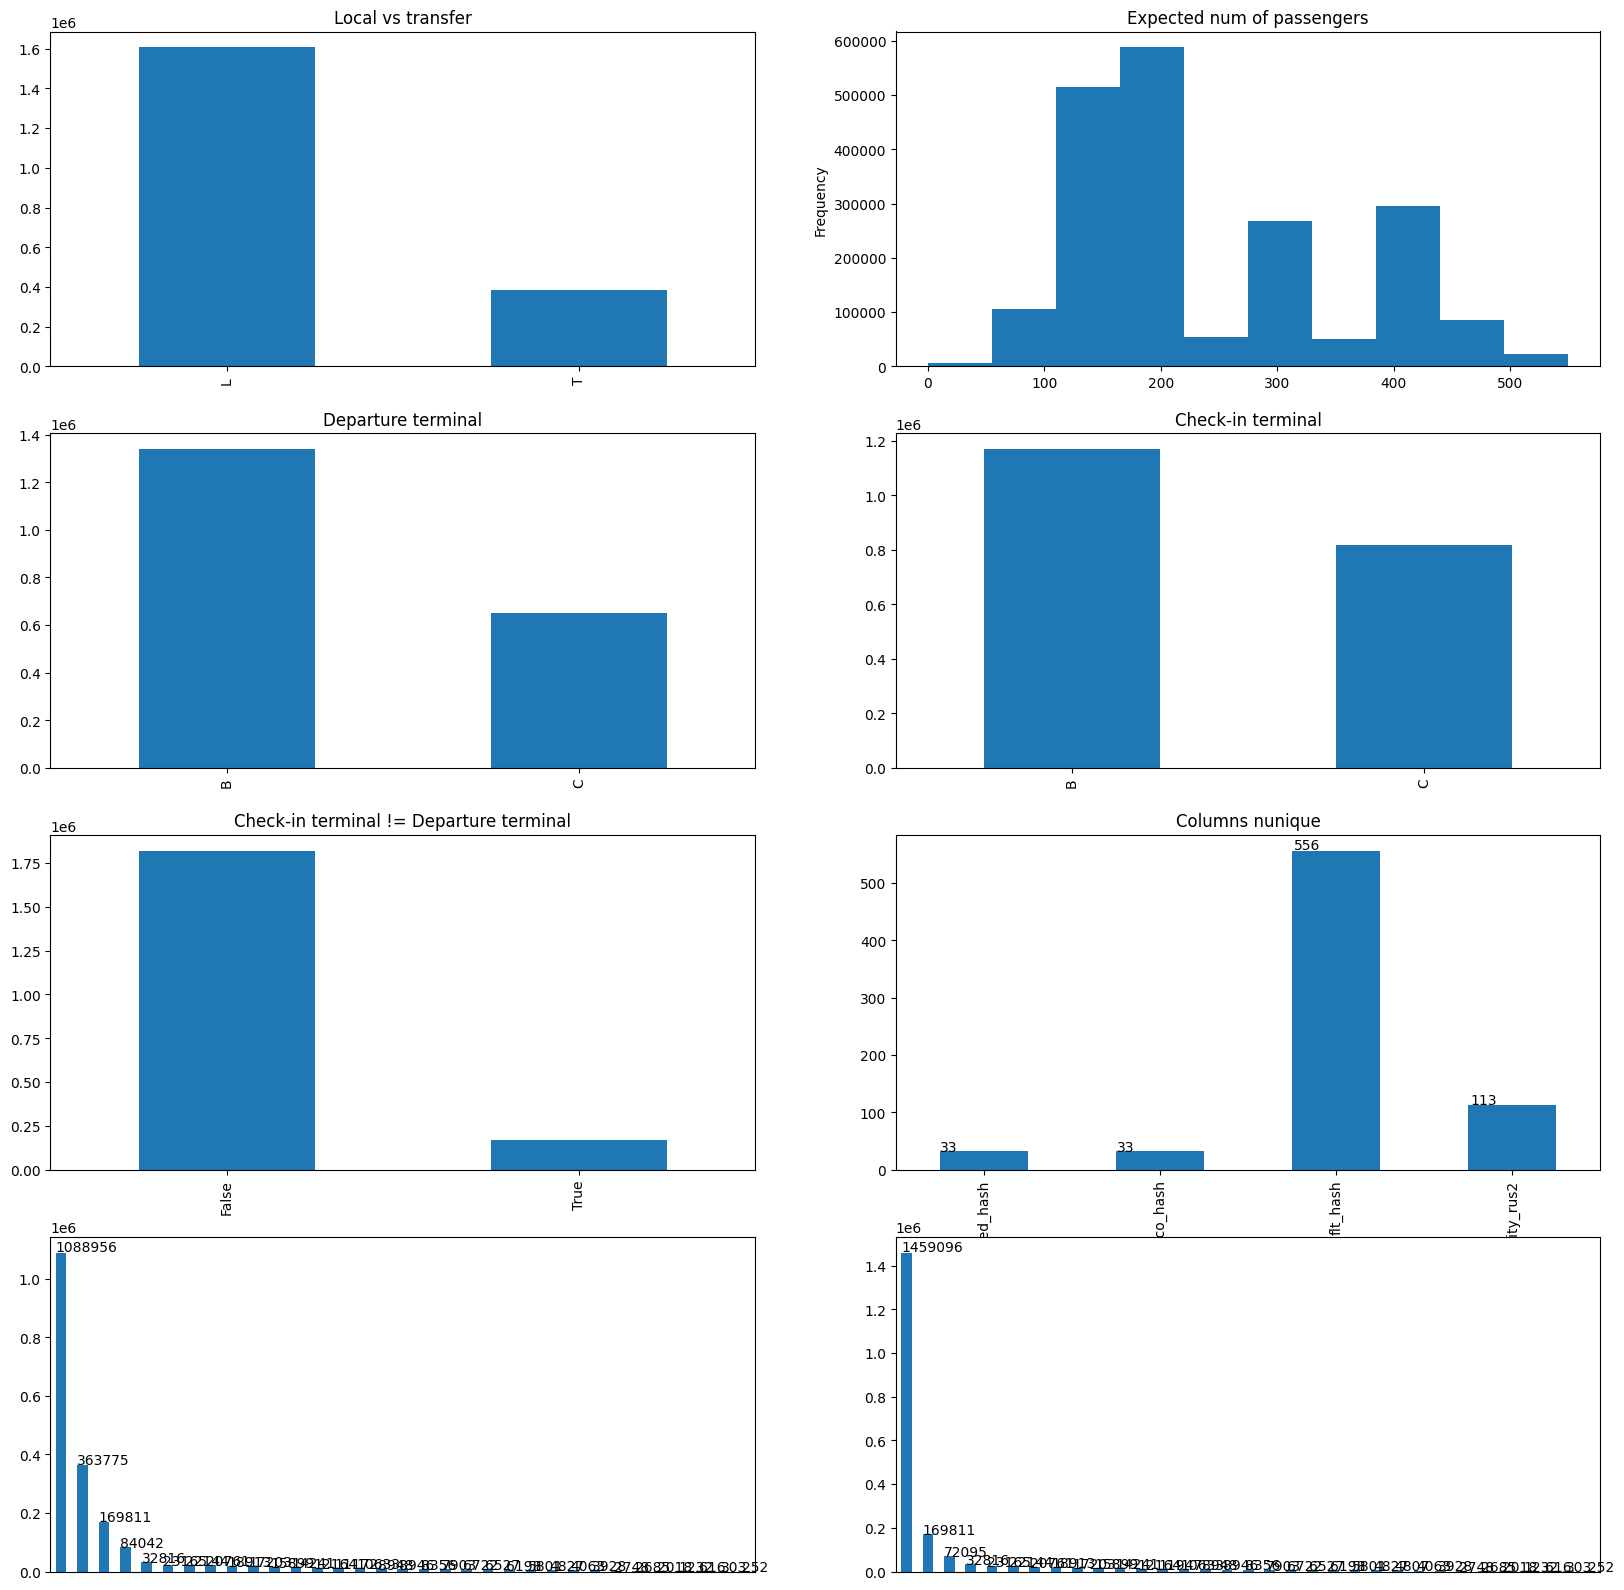

In [6]:
fig, axes = plt.subplots(ncols=2, nrows=4, figsize=(20, 20))


main_df.local_or_transfer.value_counts().plot.bar(ax=axes[0, 0])
main_df.config.plot.hist(ax=axes[0, 1])
main_df.departure_terminal.value_counts().plot.bar(ax=axes[1, 0])
main_df.checkin_terminal.value_counts().plot.bar(ax=axes[1, 1])
(main_df.departure_terminal != main_df.checkin_terminal).value_counts().plot.bar(ax=axes[2, 0])
main_df[['airline_grouped_hash', 'cco_hash', 'flt_hash', 'm_city_rus2']].nunique().plot.bar(ax=axes[2, 1])


axes[0, 0].set_title('Local vs transfer')
axes[0, 1].set_title('Expected num of passengers')
axes[1, 0].set_title('Departure terminal')
axes[1, 1].set_title('Check-in terminal')
axes[2, 0].set_title('Check-in terminal != Departure terminal')
axes[2, 1].set_title('Columns nunique')

for p in axes[2, 1].patches:
    axes[2, 1].annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
    
main_df['airline_grouped_hash'].value_counts().plot.bar(ax=axes[3, 0])
axes[3, 0].xaxis.set_visible(False)
main_df['cco_hash'].value_counts().plot.bar(ax=axes[3, 1])
axes[3, 1].xaxis.set_visible(False)

for p in axes[3, 0].patches:
    axes[3, 0].annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
for p in axes[3, 1].patches:
    axes[3, 1].annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

# Простейший feature engineering и построении матрицы корреляции

In [7]:
main_df = main_df.drop(columns=['ident_bag', 'i_id', 'MessageReceivedDate', 'MessageProcessedDate', 'TagNumber'], errors='ignore')
main_df['is_dep_B'] = main_df.departure_terminal == 'B'
main_df['is_local'] = main_df.local_or_transfer == 'L'
main_df['departure_equals_checkin'] = (main_df['departure_terminal'] == main_df['checkin_terminal']).astype('int')
main_df = main_df.drop(columns=['local_or_transfer', 'departure_terminal', 'checkin_terminal', 'flt_hash'])

In [8]:
corr = main_df.corr()
corr.style.background_gradient(cmap='coolwarm')

,MessageReceivedMinutes,ProcessingTime,config,is_dep_B,is_local,departure_equals_checkin
MessageReceivedMinutes,1.000000,-0.024186,0.018298,0.003785,-0.007039,0.018626
ProcessingTime,-0.024186,1.000000,0.009420,0.001757,-0.011911,0.003421
config,0.018298,0.009420,1.000000,-0.201550,0.127409,0.147661
is_dep_B,0.003785,0.001757,-0.201550,1.000000,-0.227080,-0.207977
is_local,-0.007039,-0.011911,0.127409,-0.227080,1.000000,-0.075917
departure_equals_checkin,0.018626,0.003421,0.147661,-0.207977,-0.075917,1.000000


# Запись данных для обучения

In [10]:
main_df['config'] /= main_df.config.max()
X = main_df.drop(columns=['airline_grouped_hash', 'cco_hash', 'm_city_rus2']).groupby('MessageReceivedMinutes').mean()
X

,ProcessingTime,config,is_dep_B,is_local,departure_equals_checkin
MessageReceivedMinutes,,,,,
0,2.500000,0.465455,0.750000,0.833333,1.000000
1,2.625000,0.405909,0.625000,0.750000,0.958333
2,2.285714,0.337922,0.714286,0.714286,0.785714
3,2.631579,0.341914,0.526316,0.894737,1.000000
4,3.000000,0.392386,0.500000,0.750000,0.937500
...,...,...,...,...,...
89275,2.000000,0.596364,0.392857,0.785714,1.000000
89276,1.964286,0.593506,0.321429,0.892857,1.000000
89277,2.103448,0.590219,0.413793,0.931034,1.000000


In [12]:
X.to_csv('x_v1.csv', index=False)
target.to_csv('target.csv', index=False)